# accelerating k-means with a gpu

plan:
- how k-means works:
  - given a dataset of n points, and hyperparameter k that represents the number of clusters, the goal of k-means is to group the data points into k clusters
  - it works in the following way:
    - start with k random points from the dataset as centroids. each centroid represents a cluster.
    - till convergence:
      - for each point in the dataset, calculate the distance to each of the centroids. assign it to the closest centroid (maybe maintain a list for each centroid? to track which points belong to which cluster?)
      - go through points in each cluster, and calculate a new cluster center (by taking the average of all points within each cluster)
- how do we implement in pure python
  - dataset
    - k = 6
    - generate 500 datapoints (2 dimensional) using multivariate gaussian distribution around each centroid (6 * 500 => 3000 points)
    - run k-means
    - epochs: till no point changes centers
  - algo
  - measuring time
  - plot and animation?
- implement using broadcasting
- running it on the gpu

### dataset generation

In [ ]:
import torch, matplotlib.pyplot as plt, math

In [ ]:
torch.manual_seed(100040052040)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [ ]:
k = 6
n_samples = 500

In [ ]:
centroids = torch.rand(k,2)*70-35

In [ ]:
centroids

tensor([[-27.810, -22.708],
        [-16.853,   0.534],
        [ 17.428,  20.302],
        [ -3.617, -30.630],
        [ 13.090,  13.985],
        [ -2.812,  15.719]])

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
cov = torch.diag(tensor([5., 5.]))
def sample(m): return MultivariateNormal(m, cov).sample((n_samples,))

In [ ]:
data = [sample(c) for c in centroids]

In [ ]:
data = torch.cat(data)

In [ ]:
data.shape, data[:10]

(torch.Size([3000, 2]),
 tensor([[-23.992, -21.491],
         [-27.728, -21.238],
         [-25.793, -23.305],
         [-26.527, -24.786],
         [-29.919, -25.113],
         [-24.891, -23.651],
         [-28.547, -24.092],
         [-31.039, -19.372],
         [-26.376, -24.834],
         [-27.094, -27.280]]))

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

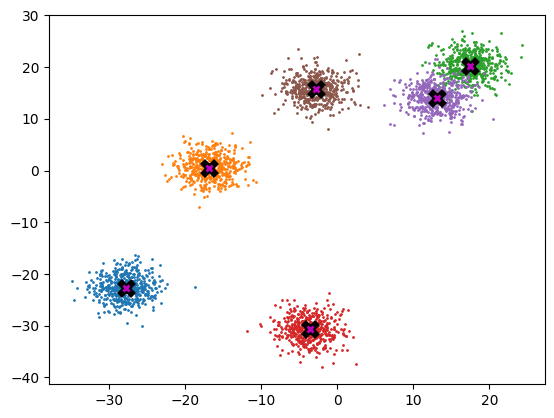

In [ ]:
plot_data(centroids, data, n_samples)

K-Means

In [ ]:
centroids

tensor([[-27.810, -22.708],
        [-16.853,   0.534],
        [ 17.428,  20.302],
        [ -3.617, -30.630],
        [ 13.090,  13.985],
        [ -2.812,  15.719]])

In [ ]:
def distance(a, b):
  return ((a-b)**2).sum(dim=-1).sqrt()

In [ ]:
data[0].shape, data[1].shape, centroids[0].shape

(torch.Size([2]), torch.Size([2]), torch.Size([2]))

In [ ]:
distance(data[0], data[1])

tensor(3.744)

In [ ]:
a = tensor([[3., 3.], [4., 4.]])
b = tensor([[1., 1.]])
a.shape, b.shape, distance(a, b)

(torch.Size([2, 2]), torch.Size([1, 2]), tensor([2.828, 4.243]))

In [ ]:
def k_means_plus_plus(data, k):
  # goal is to pick k points from data as initial centroids that are as further away from each other as possible
  """
  steps:
  - maintain a set of centroids and pick the first centroid at random
  - for subsequent k-1 centroids:
    - go through each point x in data one at a time
    - compute the distance to the closest existing centroid (by taking one centroid at a time and computing distance)
    - assign a probability to this point based on closest_centroid_distance**2
    - sample based on this probability
  """
  idx = torch.randint(0, len(data), (1,))
  first_centroid = data[idx][0]
  centroids = [first_centroid]

  for _ in range(k-1):
    # find distances to existing centroids and assign weights
    distances, weights = [], []
    for x in data:
      dist = math.inf
      for c in centroids:
        curr_dist = distance(c, x).item()
        if curr_dist < dist: dist = curr_dist
      distances.append(dist)

    tot_dist = sum(d*d for d in distances)
    weights = [(dist**2)/tot_dist for dist in distances]

    # sample based on weights to generate a new centroid
    centroid_idx = torch.multinomial(torch.tensor(weights), 1)
    centroids.append(data[centroid_idx.item()])

  return torch.stack(centroids)

In [ ]:
init_centroids = k_means_plus_plus(data, 6)

In [ ]:
init_centroids

tensor([[ -6.367, -31.013],
        [ -3.366,  16.230],
        [-17.307,   4.185],
        [ 13.508,  17.035],
        [-28.706, -21.339],
        [ 17.108,  22.363]])

In [ ]:
def update_centroids(centroid_map, cluster_map, data):
  stop_flag = True
  for cent, points in cluster_map.items():
    if not points:
      idx = torch.randint(0, len(data), (1,))
      new_centroid = data[idx][0]
    else:
      points = torch.stack(points)
      new_centroid = points.mean(dim=0)
    if torch.norm(new_centroid - centroid_map[cent]) > 1e-2: stop_flag = False
    centroid_map[cent] = new_centroid
  return centroid_map, dict(), stop_flag

In [ ]:
def k_means(data, k=6):
    # pick k points at random
    # centroids = torch.rand((k, 2))*70-35
    # indices = torch.randperm(len(data))[:k]
    # centroids = data[indices]
    centroids = k_means_plus_plus(data, k)
    centroid_map = dict() # key: centroid_id, value: coordinates of centroid
    cluster_map = dict()
    for i, c in enumerate(centroids):
        centroid_map[i] = c
    stop_flag = False

    i = 0

    wccs_tracker = []

    while not stop_flag and i < 300:
      wccs = 0
      cluster_map = {c_id: [] for c_id in centroid_map.keys()}
      for x in data:
          closest_centroid_id, centroid_distance = -1, math.inf
          for c_id, coords in centroid_map.items():
              dist = distance(x, coords)
              if dist.item() < centroid_distance:
                  closest_centroid_id = c_id
                  centroid_distance = dist.item()
          cluster_map[closest_centroid_id].append(x)
          wccs += distance(centroid_map[closest_centroid_id], x)**2
      centroid_map, cluster_map, stop_flag = update_centroids(centroid_map, cluster_map, data)
      wccs_tracker.append(wccs)
      i += 1

    return centroid_map, wccs_tracker

In [ ]:
c, wccs_tracker = k_means(data, k=6)

In [ ]:
c

{0: tensor([ -3.805, -30.674]),
 1: tensor([17.351, 20.347]),
 2: tensor([-2.976, 15.799]),
 3: tensor([12.905, 13.920]),
 4: tensor([-27.932, -22.579]),
 5: tensor([-16.791,   0.668])}

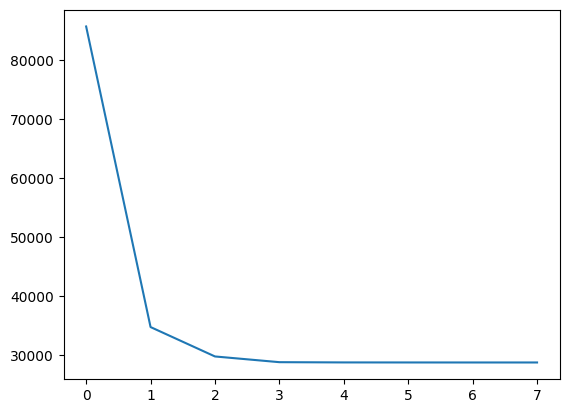

In [ ]:
plt.plot(wccs_tracker)

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

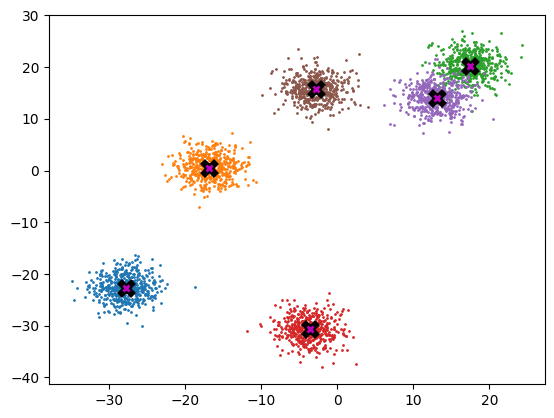

In [ ]:
plot_data(centroids, data, n_samples)

In [ ]:
centroids, torch.stack(list(c.values()))

(tensor([[-27.810, -22.708],
         [-16.853,   0.534],
         [ 17.428,  20.302],
         [ -3.617, -30.630],
         [ 13.090,  13.985],
         [ -2.812,  15.719]]),
 tensor([[ -3.805, -30.674],
         [ 17.351,  20.347],
         [ -2.976,  15.799],
         [ 12.905,  13.920],
         [-27.932, -22.579],
         [-16.791,   0.668]]))

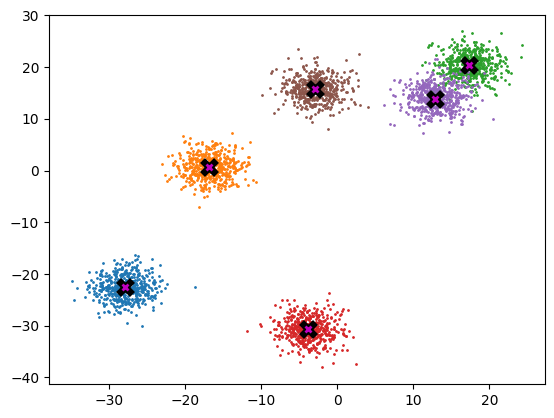

In [ ]:
plot_data(torch.stack(list(c.values())), data, n_samples)

In [ ]:
# %time res=k_means(data, k=6)

## optimize with broadcasting

In [ ]:
def k_means_pp_broad(data, k):
  idx = torch.randint(0, len(data), (1,))
  first_centroid = data[idx][0]
  centroids = [first_centroid]

  for _ in range(k-1):
    dist = ((data[:, None, :] - torch.stack(centroids)[None, :, :])**2).sum(dim=-1) # shape at the end: (3000, c)
    min_dist_sq = dist.min(dim=-1).values # shape: (3000,)
    weights = min_dist_sq/min_dist_sq.sum() # shape (3000,)
    centroid_idx = torch.multinomial(weights, 1)
    centroids.append(data[centroid_idx.item()])

  return torch.stack(centroids)

In [ ]:
# %time tmp=k_means_plus_plus(data, 50)

In [ ]:
# %time tmp=k_means_pp_broad(data, 50)

In [ ]:
def k_means_broad(data, k=6):
    centroids = k_means_pp_broad(data, k) # shape: (k,2)
    for _ in range(300):
        dist_sq = ((data[:,None,:] - centroids[None,:,:])**2).sum(dim=-1) #shape: 3000,k
        assignments = dist_sq.argmin(dim=1) #shape: (N,)

        # compute new centroids
        out = torch.zeros((centroids.shape[0], centroids.shape[1])) # (k,2)
        out.scatter_add_(0, assignments.unsqueeze(1).expand_as(data), data)

        counts = torch.zeros(centroids.shape[0])  # (k,) instead of (k,1)
        counts.scatter_add_(0, assignments, torch.ones_like(assignments, dtype=data.dtype))

        # Handle empty clusters
        empty_clusters = (counts == 0)
        if empty_clusters.any():
            # Get random indices for empty clusters
            n_empty = empty_clusters.sum().item()
            random_indices = torch.randint(0, data.shape[0], (n_empty,))

            # Assign random data points to empty clusters
            out[empty_clusters] = data[random_indices]
            counts[empty_clusters] = 1

        new_centroids = out/counts.unsqueeze(1)  # unsqueeze for broadcasting

        if ((centroids-new_centroids)**2).sum().sqrt() <= 1e-2: break

        centroids = new_centroids

    return centroids

In [ ]:
def k_means_broad_gpu(data, k=6):
    # Move data to GPU and get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)

    centroids = k_means_pp_broad(data, k).to(device)  # shape: (k,2)

    for _ in range(300):
        dist_sq = ((data[:,None,:] - centroids[None,:,:])**2).sum(dim=-1) #shape: 3000,k
        assignments = dist_sq.argmin(dim=1) #shape: (N,)

        # compute new centroids - create tensors on GPU
        out = torch.zeros((centroids.shape[0], centroids.shape[1]), device=device) # (k,2)
        out.scatter_add_(0, assignments.unsqueeze(1).expand_as(data), data)

        counts = torch.zeros(centroids.shape[0], device=device)  # (k,) on GPU
        counts.scatter_add_(0, assignments, torch.ones_like(assignments, dtype=data.dtype))

        # Handle empty clusters
        empty_clusters = (counts == 0)
        if empty_clusters.any():
            # Get random indices for empty clusters - create on GPU
            n_empty = empty_clusters.sum().item()
            random_indices = torch.randint(0, data.shape[0], (n_empty,), device=device)

            # Assign random data points to empty clusters
            out[empty_clusters] = data[random_indices]
            counts[empty_clusters] = 1

        new_centroids = out/counts.unsqueeze(1)  # unsqueeze for broadcasting

        if ((centroids-new_centroids)**2).sum().sqrt() <= 1e-2: break

        centroids = new_centroids

    return centroids

In [ ]:
c = k_means_broad(data, k=6)

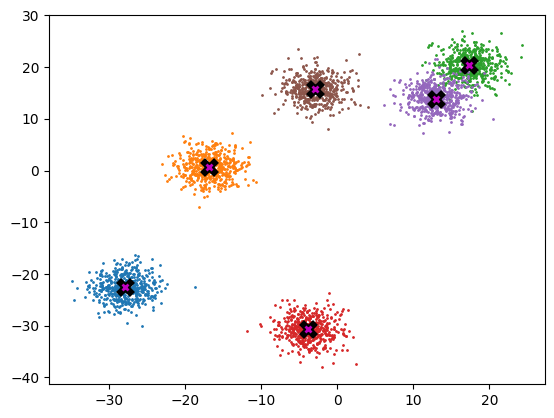

In [ ]:
plot_data(c, data, n_samples)

In [ ]:
c = k_means_broad_gpu(data, k=6)

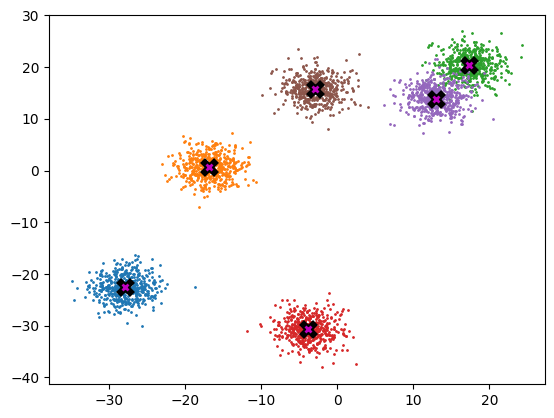

In [ ]:
plot_data(c.cpu(), data.cpu(), n_samples)

In [ ]:
%timeit -n 3 k_means(data, k=6)

3.85 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [ ]:
%timeit -n 50 k_means_broad(data, k=6)

11.3 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [ ]:
%timeit -n 50 k_means_broad_gpu(data, k=6)

4.46 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## batched k means

In [ ]:
def k_means_broad_gpu_batched(data, k=6, B=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)

    N, D = data.shape
    data_batched = data.unsqueeze(0).expand(B, N, D)  # (B,N,D)

    centroids = torch.stack([k_means_pp_broad(data, k) for _ in range(B)], dim=0).to(device)

    for _ in range(300):
        dist_sq = ((data_batched[:, :, None, :] - centroids[:, None, :, :]) ** 2).sum(dim=-1)  # (B,N,k)
        assignments = dist_sq.argmin(dim=2)  # (B,N)

        out = torch.zeros((B, k, D), device=device)
        out.scatter_add_(1, assignments.unsqueeze(2).expand(B, N, D), data_batched)

        counts = torch.zeros((B, k), device=device)
        counts.scatter_add_(1, assignments, torch.ones_like(assignments, dtype=data.dtype))

        empty_clusters = (counts == 0)
        if empty_clusters.any():
            for b in range(B):
                if empty_clusters[b].any():
                    n_empty = empty_clusters[b].sum().item()
                    random_indices = torch.randint(0, N, (n_empty,), device=device)
                    out[b, empty_clusters[b]] = data[random_indices]
                    counts[b, empty_clusters[b]] = 1

        new_centroids = out / counts.unsqueeze(2)

        shift = ((centroids - new_centroids) ** 2).sum(dim=(1, 2)).sqrt()
        if (shift <= 1e-2).all():
            break

        centroids = new_centroids

    inertia = torch.stack([
        ((data - centroids[b][assignments[b]]) ** 2).sum() for b in range(B)
    ])
    best_idx = inertia.argmin()

    return centroids[best_idx]


In [ ]:
def k_means_broad_cpu_batched(data, k=6, B=16):
    device = torch.device('cpu')
    data = data.to(device)

    N, D = data.shape
    data_batched = data.unsqueeze(0).expand(B, N, D)  # (B,N,D)

    centroids = torch.stack([k_means_pp_broad(data, k) for _ in range(B)], dim=0).to(device)

    for _ in range(300):
        dist_sq = ((data_batched[:, :, None, :] - centroids[:, None, :, :]) ** 2).sum(dim=-1)  # (B,N,k)
        assignments = dist_sq.argmin(dim=2)  # (B,N)

        out = torch.zeros((B, k, D), device=device)
        out.scatter_add_(1, assignments.unsqueeze(2).expand(B, N, D), data_batched)

        counts = torch.zeros((B, k), device=device)
        counts.scatter_add_(1, assignments, torch.ones_like(assignments, dtype=data.dtype))

        empty_clusters = (counts == 0)
        if empty_clusters.any():
            for b in range(B):
                if empty_clusters[b].any():
                    n_empty = empty_clusters[b].sum().item()
                    random_indices = torch.randint(0, N, (n_empty,), device=device)
                    out[b, empty_clusters[b]] = data[random_indices]
                    counts[b, empty_clusters[b]] = 1

        new_centroids = out / counts.unsqueeze(2)

        shift = ((centroids - new_centroids) ** 2).sum(dim=(1, 2)).sqrt()
        if (shift <= 1e-2).all():
            break

        centroids = new_centroids

    inertia = torch.stack([
        ((data - centroids[b][assignments[b]]) ** 2).sum() for b in range(B)
    ])
    best_idx = inertia.argmin()

    return centroids[best_idx]


In [ ]:
%timeit -n 2 k_means_broad_cpu_batched(data, k=6, B=512)

14.5 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [ ]:
%timeit -n 2 k_means_broad_gpu_batched(data, k=6, B=512)

983 ms ± 87.8 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
